In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import pickle

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import featurewiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval

# fix random seed
import random
random.seed(0)
np.random.seed(0)
torch.random.manual_seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# all seeds where randomness could be introduced are set, the only "randomness" left is within CUDAs convolution 
# benchmarking as well as choice of non-deterministic algorithms (https://pytorch.org/docs/stable/notes/randomness.html)

Imported 0.2.8 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [2]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df, test_size = 0.3)
num_classes = y_train.nunique()

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpc_local2_max,lpc_local2_min,lpc_local3_mean,lpc_local3_var,lpc_local3_max,lpc_local3_min,lpc_local4_mean,lpc_local4_var,lpc_local4_max,lpc_local4_min
383,0.173964,-0.166713,-0.039438,0.733353,0.461556,-0.381409,-0.304134,0.446530,0.248546,-0.354145,...,-0.363162,-0.776774,0.424712,0.363032,2.317950,0.048530,-0.128417,0.318869,0.144952,-0.050155
180,0.950873,1.224927,1.899798,-1.397406,-0.652108,0.731989,0.851705,0.214744,0.496884,-0.528797,...,-0.225909,0.723289,1.169122,-0.838891,0.192236,0.780699,-1.360290,-1.153810,-2.399633,-0.789542
447,-0.148141,1.683795,2.525357,-2.124781,-0.650839,1.041327,1.124535,1.541140,1.457745,-1.088962,...,-1.810723,0.177150,0.590148,-1.787102,-1.486885,1.656247,-1.705398,0.730077,-1.144829,-0.653880
409,-1.122426,-1.055640,-0.939915,0.733353,3.283787,-0.993784,-1.149465,-0.034375,-0.282702,0.074134,...,-1.033402,1.591038,-0.311790,-0.653266,-0.173165,0.861124,0.225703,-0.650867,0.139890,1.094568
268,0.023864,-0.685753,-0.643597,0.733353,-0.193242,-0.656372,-0.655108,0.738204,0.570754,-0.578041,...,-0.219732,1.302735,0.964428,-0.290598,0.284147,0.249380,-1.363972,-0.899952,-1.962672,-0.445036


There are 374 entries with 269 columns in the training data.
There are 161 entries with 269 columns in the testing data.


In [3]:
# split test set into validation and test data
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test')

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpc_local2_max,lpc_local2_min,lpc_local3_mean,lpc_local3_var,lpc_local3_max,lpc_local3_min,lpc_local4_mean,lpc_local4_var,lpc_local4_max,lpc_local4_min
427,-0.081213,-0.501545,-0.327525,0.731704,0.303440,-0.626350,-0.614883,0.546508,0.358990,-0.433612,...,0.541099,0.354995,1.119689,0.482875,0.699955,-0.343296,-1.438137,0.272696,-0.562082,0.252035
70,2.766501,1.061992,0.441255,0.733353,-0.466328,1.088422,1.164748,-1.268877,-1.646436,1.699005,...,-1.657933,-1.109443,1.637391,-0.755403,1.527315,0.840948,-0.861776,1.137030,1.241878,-0.988847
509,1.371605,1.336603,2.023263,0.733353,0.457749,0.911618,1.012033,-0.576282,-0.881338,0.672025,...,0.308740,-0.988664,1.137387,-0.272122,0.981785,-0.101179,-1.267076,-0.460619,-0.157696,-0.269461
387,3.344756,-0.416257,-0.823034,-1.461732,-0.652108,-0.415476,-0.345660,-2.152901,-0.763640,0.542812,...,-1.677667,-1.142151,0.871595,-1.422689,-0.695810,1.105674,-1.173203,0.072963,-0.409148,-1.388598
299,0.558008,0.773697,1.117848,-0.950661,-0.652108,0.374771,0.515043,0.491012,0.297685,-0.389869,...,-1.093813,-0.902777,-0.252188,-0.281444,0.778132,0.380579,0.970258,1.602301,0.816277,-1.574893


There are 80 entries with 269 columns in the validation data.
There are 81 entries with 269 columns in the testing data.


In [4]:
# define a tabluar dataset with torch
class TabularDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx].values, dtype=torch.float)
        y = torch.tensor(self.target.iloc[idx], dtype=torch.long)
        return x, y

In [5]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

# set hyperparameters
BATCH_SIZE = 32
HIDDEN_SIZE = 64
EPOCHS = 25
patience = 2

Device state: cpu


In [6]:
# to make dataloader reproducable (https://pytorch.org/docs/stable/notes/randomness.html)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [7]:
# define train, test, and val loader
# shuffle is set to false to make it reproducible
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

# MLP-FFNN

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        return x

In [9]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [10]:
# to make training reproducible
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, batch_size=BATCH_SIZE, num_epochs=EPOCHS, patience=patience):
    # set random seed
    set_seed() 
    
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_val_f1_score = 0.0
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.tolist())
                val_labels.extend(labels.tolist())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 Macro: {val_f1:.4f}")
        
        if val_f1 > best_val_f1_score:
            best_val_f1_score = val_f1
            best_model_weights = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == patience:
                print(f"No improvement in val F1 macro score for {patience} epochs, stopping training early")
                break
        
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses, val_f1_scores

In [12]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8631, Val Loss: 1.7128, Val F1 Macro: 0.3188
Epoch 2/25, Train Loss: 1.5710, Val Loss: 1.3932, Val F1 Macro: 0.2354
Epoch 3/25, Train Loss: 1.2699, Val Loss: 1.1518, Val F1 Macro: 0.4180
Epoch 4/25, Train Loss: 1.0181, Val Loss: 0.9741, Val F1 Macro: 0.4716
Epoch 5/25, Train Loss: 0.8225, Val Loss: 0.8466, Val F1 Macro: 0.6199
Epoch 6/25, Train Loss: 0.6535, Val Loss: 0.7203, Val F1 Macro: 0.7247
Epoch 7/25, Train Loss: 0.5076, Val Loss: 0.6063, Val F1 Macro: 0.7725
Epoch 8/25, Train Loss: 0.3905, Val Loss: 0.5231, Val F1 Macro: 0.8311
Epoch 9/25, Train Loss: 0.3022, Val Loss: 0.4665, Val F1 Macro: 0.8744
Epoch 10/25, Train Loss: 0.2364, Val Loss: 0.4285, Val F1 Macro: 0.8862
Epoch 11/25, Train Loss: 0.1856, Val Loss: 0.4037, Val F1 Macro: 0.8636
Epoch 12/25, Train Loss: 0.1462, Val Loss: 0.3886, Val F1 Macro: 0.8760
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
99.19% for the train data
82.73% for the test data

Evaluation: accuracy_score
99.20% for the train data
83.95% for the test data

Evaluation: precision_score
99.30% for the train data
86.03% for the test data

Evaluation: recall_score
99.10% for the train data
82.42% for the test data

Evaluation: confusion_matrix of test predictions


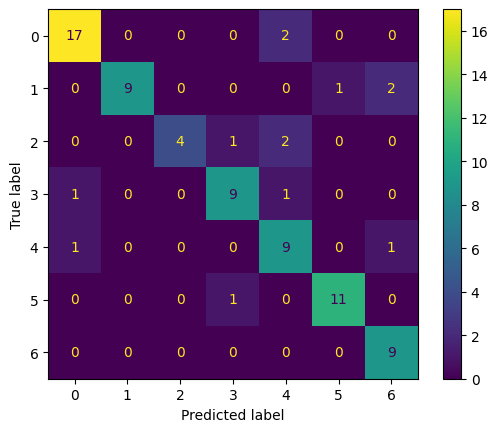


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']



In [13]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

In [14]:
# save model
pickle.dump(model, open('../results/models/MLPFFNN_best_model_all_numerical_features.pkl', 'wb'))

# GFFNN (skip connections)

In [15]:
class MLPWithSkip(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPWithSkip, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.skip_connection = nn.Linear(input_size, hidden_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        hidden1 = self.relu(self.fc1(x))
        hidden2 = self.relu(self.fc2(hidden1))
        
        # Apply skip connection from input to second hidden layer
        skip = self.skip_connection(x)
        hidden2_skip = hidden2 + skip
        
        output = self.fc3(hidden2_skip)
        return output

In [16]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [17]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.6043, Val Loss: 1.2077, Val F1 Macro: 0.6009
Epoch 2/25, Train Loss: 0.9813, Val Loss: 0.9143, Val F1 Macro: 0.6461
Epoch 3/25, Train Loss: 0.7208, Val Loss: 0.7541, Val F1 Macro: 0.6891
Epoch 4/25, Train Loss: 0.5561, Val Loss: 0.6236, Val F1 Macro: 0.7410
Epoch 5/25, Train Loss: 0.4395, Val Loss: 0.5428, Val F1 Macro: 0.8091
Epoch 6/25, Train Loss: 0.3500, Val Loss: 0.4836, Val F1 Macro: 0.8219
Epoch 7/25, Train Loss: 0.2794, Val Loss: 0.4418, Val F1 Macro: 0.8503
Epoch 8/25, Train Loss: 0.2226, Val Loss: 0.4151, Val F1 Macro: 0.8503
Epoch 9/25, Train Loss: 0.1768, Val Loss: 0.3958, Val F1 Macro: 0.8637
Epoch 10/25, Train Loss: 0.1399, Val Loss: 0.3811, Val F1 Macro: 0.8905
Epoch 11/25, Train Loss: 0.1100, Val Loss: 0.3702, Val F1 Macro: 0.8715
Epoch 12/25, Train Loss: 0.0865, Val Loss: 0.3629, Val F1 Macro: 0.8715
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
99.78% for the train data
80.58% for the test data

Evaluation: accuracy_score
99.73% for the train data
81.48% for the test data

Evaluation: precision_score
99.84% for the train data
83.62% for the test data

Evaluation: recall_score
99.71% for the train data
79.93% for the test data

Evaluation: confusion_matrix of test predictions


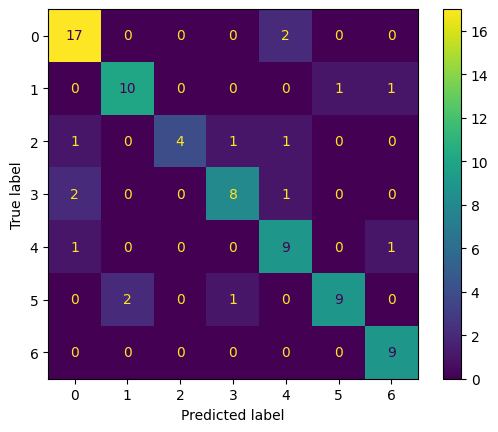


Hard cases for the model:



In [18]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Repeat with most important features
### MLP

In [19]:
# load the data with most important features
df = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df, test_size=0.3)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,rms_min,mfccs5_mean,zcr_max,duration_rising_pitch_max,lpccs_local4_min,lfccs9_max,min,energy_median,lfccs0_median,lpccs_global_median,...,value_falling_pitch_min,log_energy_entropy_mean,duration_falling_pitch_max,mfccs8_min,delta2_mfccs6_var,rms_max,f1_avg_change_rate_max,lpc_local1_var,f4_std,value_falling_pitch_max
383,-0.619440,-0.883268,1.389597,-0.431252,-0.059150,-0.874059,0.461556,0.732972,1.231243,-0.349875,...,0.553724,1.763171,-0.158909,-0.272260,0.424229,-0.604866,-0.371080,0.342967,1.053712,-0.036110
180,1.111373,2.981771,-2.109380,-0.348035,0.503161,0.652309,-0.652108,1.744806,-0.446723,-0.711983,...,-2.365758,1.327334,0.974641,0.539483,-0.076613,0.048643,0.343799,-0.747024,0.117057,0.323015
447,2.035391,2.016252,-0.712467,-0.472861,-0.813299,-0.060700,-0.650839,0.576918,2.368897,-1.147182,...,0.734583,-1.736709,-1.211491,0.700281,0.123406,0.517849,2.483163,-0.211176,0.684359,0.302117
409,-0.601969,-0.067690,0.492538,-0.472861,0.688789,-1.108780,3.283787,0.199894,1.001981,1.232069,...,-0.071742,0.232601,1.703351,0.593645,3.025175,-1.511575,-2.120813,-0.853909,-0.650691,0.243999
268,-0.727106,-1.481929,-1.069505,-0.389644,1.148437,-1.773846,-0.193242,0.125970,0.573460,0.855085,...,0.853313,1.048484,-0.401812,-0.012374,0.843503,-1.059211,-1.728739,-0.511559,-0.772848,0.327307


There are 374 entries with 97 columns in the training data.
There are 161 entries with 97 columns in the testing data.


In [20]:
# define train, test, and val loader
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

In [21]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [22]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8660, Val Loss: 1.7457, Val F1 Macro: 0.3183
Epoch 2/25, Train Loss: 1.6566, Val Loss: 1.4970, Val F1 Macro: 0.3545
Epoch 3/25, Train Loss: 1.4021, Val Loss: 1.2670, Val F1 Macro: 0.3998
Epoch 4/25, Train Loss: 1.1717, Val Loss: 1.0781, Val F1 Macro: 0.3985
Epoch 5/25, Train Loss: 0.9727, Val Loss: 0.9291, Val F1 Macro: 0.5614
Epoch 6/25, Train Loss: 0.8107, Val Loss: 0.8017, Val F1 Macro: 0.6703
Epoch 7/25, Train Loss: 0.6800, Val Loss: 0.7068, Val F1 Macro: 0.7181
Epoch 8/25, Train Loss: 0.5754, Val Loss: 0.6359, Val F1 Macro: 0.6989
Epoch 9/25, Train Loss: 0.4889, Val Loss: 0.5806, Val F1 Macro: 0.7286
Epoch 10/25, Train Loss: 0.4156, Val Loss: 0.5398, Val F1 Macro: 0.7444
Epoch 11/25, Train Loss: 0.3523, Val Loss: 0.5083, Val F1 Macro: 0.7576
Epoch 12/25, Train Loss: 0.2969, Val Loss: 0.4867, Val F1 Macro: 0.7611
Epoch 13/25, Train Loss: 0.2490, Val Loss: 0.4715, Val F1 Macro: 0.7928
Epoch 14/25, Train Loss: 0.2072, Val Loss: 0.4620, Val F1 Macro: 0.8055
E


Evaluation: f1_score
99.78% for the train data
74.81% for the test data

Evaluation: accuracy_score
99.73% for the train data
75.31% for the test data

Evaluation: precision_score
99.84% for the train data
76.22% for the test data

Evaluation: recall_score
99.71% for the train data
74.85% for the test data

Evaluation: confusion_matrix of test predictions


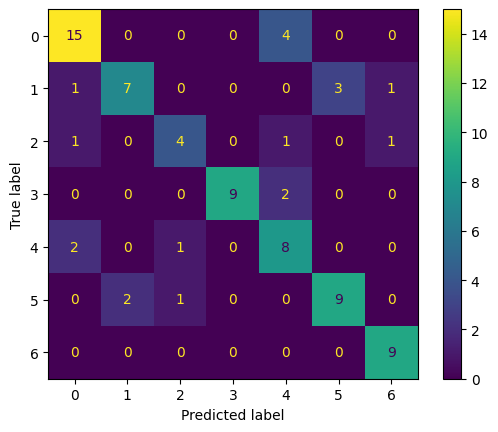


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [23]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [24]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [25]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.7740, Val Loss: 1.3926, Val F1 Macro: 0.4812
Epoch 2/25, Train Loss: 1.2456, Val Loss: 1.0587, Val F1 Macro: 0.5786
Epoch 3/25, Train Loss: 0.9628, Val Loss: 0.8724, Val F1 Macro: 0.6679
Epoch 4/25, Train Loss: 0.7804, Val Loss: 0.7491, Val F1 Macro: 0.7337
Epoch 5/25, Train Loss: 0.6477, Val Loss: 0.6574, Val F1 Macro: 0.7800
Epoch 6/25, Train Loss: 0.5452, Val Loss: 0.5915, Val F1 Macro: 0.7897
Epoch 7/25, Train Loss: 0.4630, Val Loss: 0.5447, Val F1 Macro: 0.7965
Epoch 8/25, Train Loss: 0.3946, Val Loss: 0.5111, Val F1 Macro: 0.7965
Epoch 9/25, Train Loss: 0.3364, Val Loss: 0.4881, Val F1 Macro: 0.7977
Epoch 10/25, Train Loss: 0.2859, Val Loss: 0.4722, Val F1 Macro: 0.8256
Epoch 11/25, Train Loss: 0.2417, Val Loss: 0.4628, Val F1 Macro: 0.8256
Epoch 12/25, Train Loss: 0.2032, Val Loss: 0.4581, Val F1 Macro: 0.8072
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
97.58% for the train data
78.08% for the test data

Evaluation: accuracy_score
97.59% for the train data
77.78% for the test data

Evaluation: precision_score
98.00% for the train data
80.00% for the test data

Evaluation: recall_score
97.22% for the train data
77.69% for the test data

Evaluation: confusion_matrix of test predictions


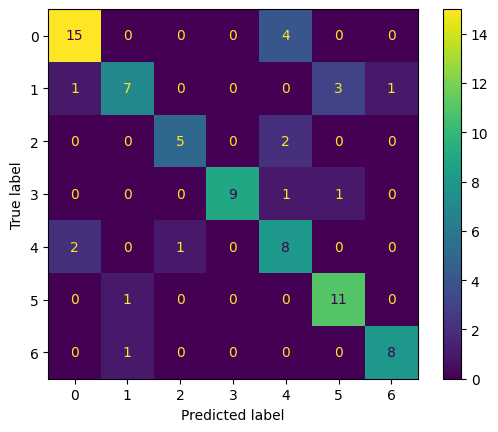


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [26]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

# Test for features paper 1
Since lists/arrays in features are not working for simple Feed Forward Neural Nets first try with statistics:

In [27]:
# load dataframe with all entries (not only numerical) - note that they are not scaled / further preprocessed
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')
df_paper1 = df_all_stats.filter(regex='label|^var$|^min$|^median$|lpc_|log_energy_entropy|shannon_entropy|threshold_entropy|sure_entropy|rms|f0|f1|f2|f3|f4')
df_paper1.columns.to_list()

['median',
 'min',
 'var',
 'f1_median',
 'f1_max',
 'f1_mean',
 'f1_std',
 'f1_var',
 'f2_median',
 'f2_max',
 'f2_mean',
 'f2_std',
 'f2_var',
 'f3_median',
 'f3_max',
 'f3_mean',
 'f3_std',
 'f3_var',
 'f4_median',
 'f4_max',
 'f4_mean',
 'f4_std',
 'f4_var',
 'rms_max',
 'rms_min',
 'rms_mean',
 'rms_median',
 'rms_var',
 'log_rms_max',
 'log_rms_min',
 'log_rms_mean',
 'log_rms_median',
 'log_rms_var',
 'lpc_global_max',
 'lpc_global_min',
 'lpc_global_mean',
 'lpc_global_median',
 'lpc_global_var',
 'lpc_local1_max',
 'lpc_local1_min',
 'lpc_local1_mean',
 'lpc_local1_median',
 'lpc_local1_var',
 'lpc_local2_max',
 'lpc_local2_min',
 'lpc_local2_mean',
 'lpc_local2_median',
 'lpc_local2_var',
 'lpc_local3_max',
 'lpc_local3_min',
 'lpc_local3_mean',
 'lpc_local3_median',
 'lpc_local3_var',
 'lpc_local4_max',
 'lpc_local4_min',
 'lpc_local4_mean',
 'lpc_local4_median',
 'lpc_local4_var',
 'shannon_entropy_max',
 'shannon_entropy_mean',
 'shannon_entropy_median',
 'shannon_entropy_

In [28]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.3)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,median,min,var,f1_median,f1_max,f1_mean,f1_std,f1_var,f2_median,f2_max,...,f3_avg_change_rate_min,f3_avg_change_rate_mean,f3_avg_change_rate_median,f3_avg_change_rate_var,f4_min,f4_avg_change_rate_max,f4_avg_change_rate_min,f4_avg_change_rate_mean,f4_avg_change_rate_median,f4_avg_change_rate_var
383,-0.039438,0.461556,-0.381409,0.109975,0.749154,-0.095229,-0.520755,-0.534501,1.592832,-0.520892,...,-0.447810,-0.510516,0.645651,-0.446794,-0.368305,-0.085934,0.512051,-0.870717,0.075705,-0.297362
180,1.899798,-0.652108,0.731989,-0.779346,0.422193,0.956602,2.375949,2.605727,-1.422960,1.926849,...,-0.833236,-0.347630,-1.235885,3.675838,-0.340975,0.828280,0.175893,-1.045572,0.205391,1.721040
447,2.525357,-0.650839,1.041327,-1.020266,2.563538,1.474111,3.109221,3.737540,0.321433,0.682151,...,-1.132030,-0.406939,-0.650150,3.190222,-0.195910,-0.455604,0.037605,-0.167319,-0.302759,0.988848
409,-0.939915,3.283787,-0.993784,0.668347,-0.834384,0.321871,-0.759715,-0.698713,-0.863763,-0.835770,...,1.091889,-0.742762,-0.222430,-1.047834,-0.120180,-1.574842,1.633455,-0.273976,-0.429416,-1.012552
268,-0.643597,-0.193242,-0.656372,1.656957,1.938499,1.243244,-0.616808,-0.602245,-0.963181,0.151561,...,0.188001,-1.364033,0.282093,-0.921787,-1.000672,-2.123276,1.680816,-0.474901,0.176639,-1.356359


There are 374 entries with 108 columns in the training data.
There are 161 entries with 108 columns in the testing data.


In [29]:
# define train, test, and val loader
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [30]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [31]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8722, Val Loss: 1.7889, Val F1 Macro: 0.1932
Epoch 2/25, Train Loss: 1.6776, Val Loss: 1.5961, Val F1 Macro: 0.3280
Epoch 3/25, Train Loss: 1.4719, Val Loss: 1.4111, Val F1 Macro: 0.3354
Epoch 4/25, Train Loss: 1.2703, Val Loss: 1.2231, Val F1 Macro: 0.4049
Epoch 5/25, Train Loss: 1.0848, Val Loss: 1.0893, Val F1 Macro: 0.4893
Epoch 6/25, Train Loss: 0.9339, Val Loss: 0.9933, Val F1 Macro: 0.5061
Epoch 7/25, Train Loss: 0.8096, Val Loss: 0.9150, Val F1 Macro: 0.6093
Epoch 8/25, Train Loss: 0.7052, Val Loss: 0.8435, Val F1 Macro: 0.6834
Epoch 9/25, Train Loss: 0.6135, Val Loss: 0.7779, Val F1 Macro: 0.7214
Epoch 10/25, Train Loss: 0.5329, Val Loss: 0.7197, Val F1 Macro: 0.7421
Epoch 11/25, Train Loss: 0.4638, Val Loss: 0.6740, Val F1 Macro: 0.7701
Epoch 12/25, Train Loss: 0.4035, Val Loss: 0.6391, Val F1 Macro: 0.7749
Epoch 13/25, Train Loss: 0.3510, Val Loss: 0.6129, Val F1 Macro: 0.7722
Epoch 14/25, Train Loss: 0.3051, Val Loss: 0.5947, Val F1 Macro: 0.7722
N


Evaluation: f1_score
93.79% for the train data
56.54% for the test data

Evaluation: accuracy_score
93.85% for the train data
59.26% for the test data

Evaluation: precision_score
93.85% for the train data
57.73% for the test data

Evaluation: recall_score
93.95% for the train data
56.78% for the test data

Evaluation: confusion_matrix of test predictions


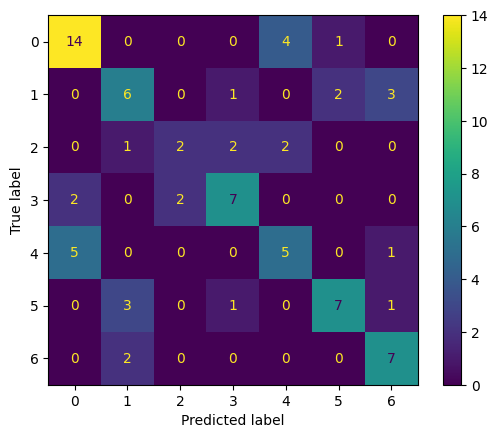


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)', 'happiness(4)']
Hard cases of false positives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [32]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [33]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [34]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.7055, Val Loss: 1.4067, Val F1 Macro: 0.4126
Epoch 2/25, Train Loss: 1.2674, Val Loss: 1.1432, Val F1 Macro: 0.5130
Epoch 3/25, Train Loss: 1.0359, Val Loss: 0.9946, Val F1 Macro: 0.5996
Epoch 4/25, Train Loss: 0.8826, Val Loss: 0.8989, Val F1 Macro: 0.6599
Epoch 5/25, Train Loss: 0.7657, Val Loss: 0.8270, Val F1 Macro: 0.6949
Epoch 6/25, Train Loss: 0.6695, Val Loss: 0.7655, Val F1 Macro: 0.7396
Epoch 7/25, Train Loss: 0.5873, Val Loss: 0.7122, Val F1 Macro: 0.7569
Epoch 8/25, Train Loss: 0.5153, Val Loss: 0.6705, Val F1 Macro: 0.7712
Epoch 9/25, Train Loss: 0.4510, Val Loss: 0.6388, Val F1 Macro: 0.7712
Epoch 10/25, Train Loss: 0.3936, Val Loss: 0.6146, Val F1 Macro: 0.8018
Epoch 11/25, Train Loss: 0.3423, Val Loss: 0.5959, Val F1 Macro: 0.7901
Epoch 12/25, Train Loss: 0.2967, Val Loss: 0.5831, Val F1 Macro: 0.7938
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
95.54% for the train data
67.98% for the test data

Evaluation: accuracy_score
95.72% for the train data
69.14% for the test data

Evaluation: precision_score
95.57% for the train data
69.73% for the test data

Evaluation: recall_score
95.62% for the train data
67.88% for the test data

Evaluation: confusion_matrix of test predictions


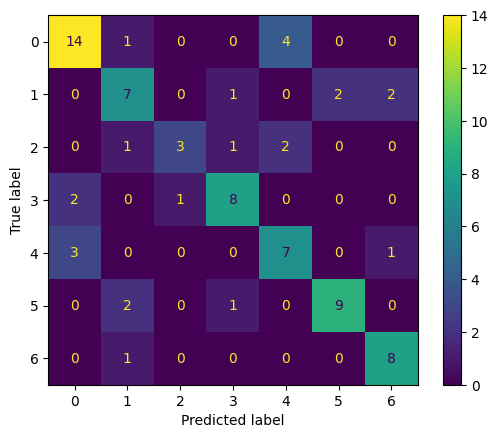


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']



In [35]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Feature Selection for Paper 1

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 109)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

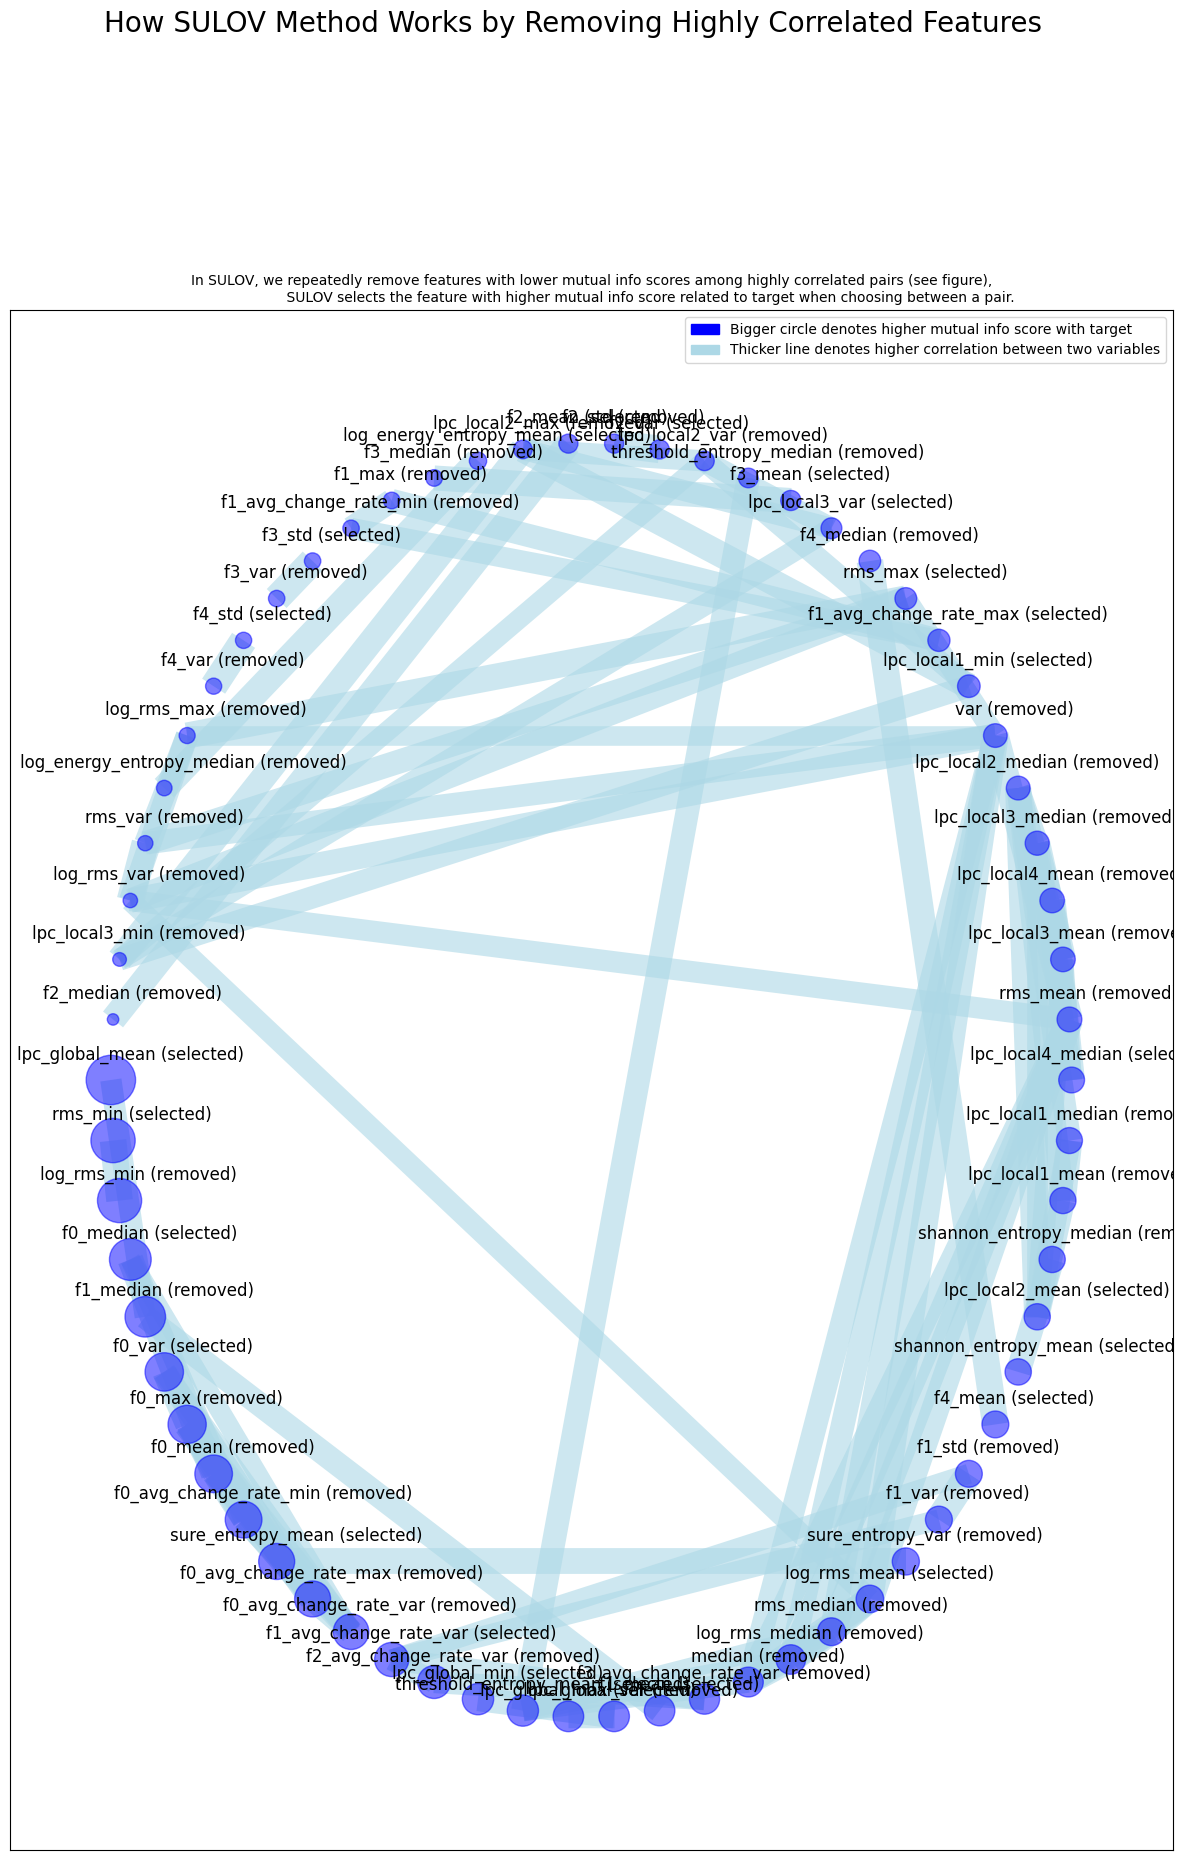

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 67
Finally 67 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 67 
    Taking top 16 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 67 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 54 variables...
            selecting 8 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
 

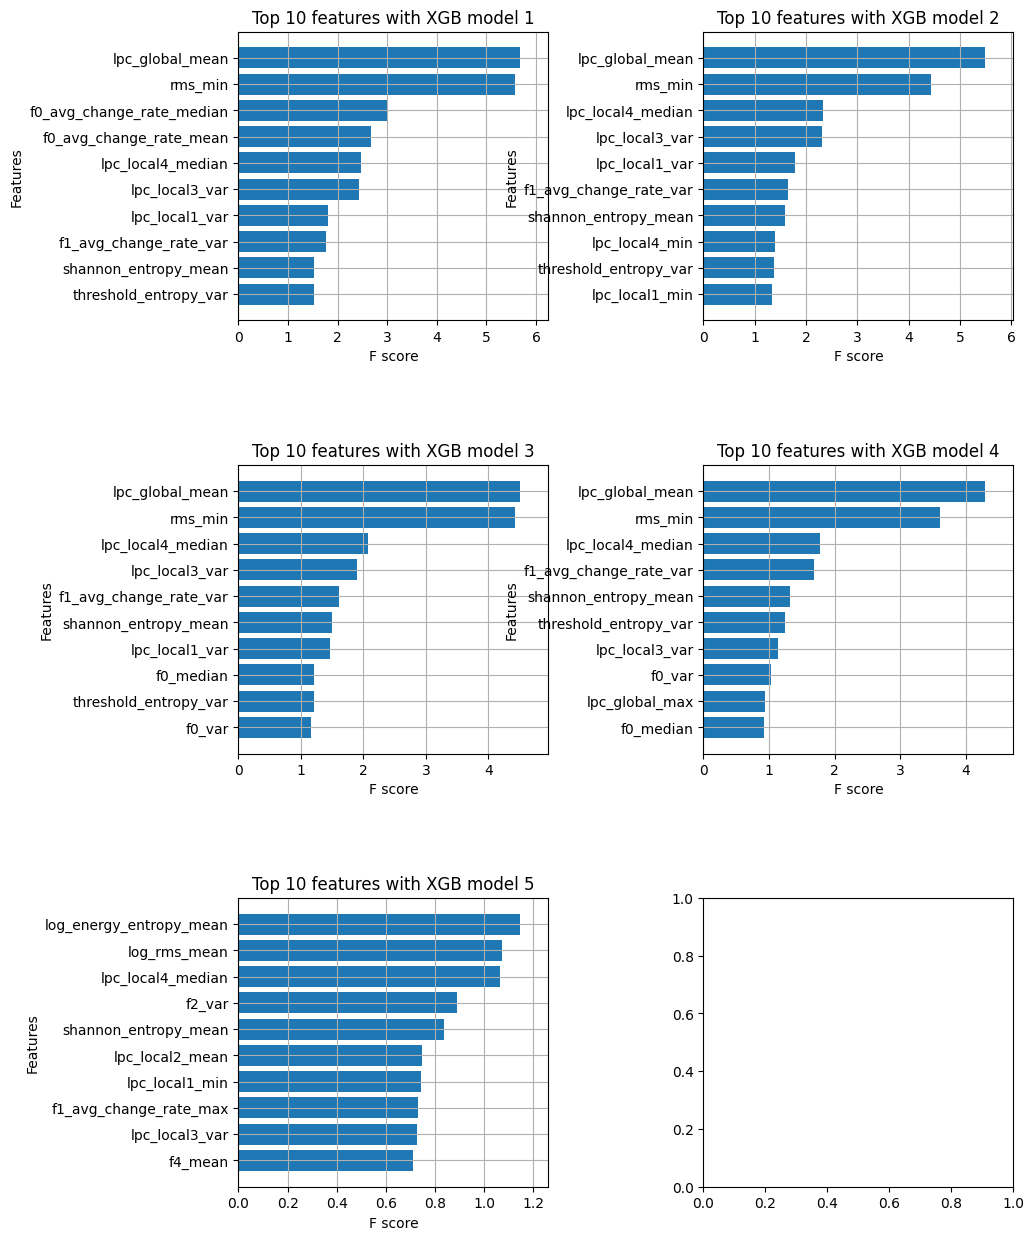

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 16 important features:
['lpc_global_mean', 'rms_min', 'f0_avg_change_rate_median', 'f0_avg_change_rate_mean', 'lpc_local4_median', 'lpc_local3_var', 'lpc_local1_var', 'f1_avg_change_rate_var', 'shannon_entropy_mean', 'threshold_entropy_var', 'shannon_entropy_max', 'f0_var', 'lpc_local3_max', 'lpc_local4_min', 'log_energy_entropy_mean', 'log_rms_mean']
Total Time taken for featurewiz selection = 8 seconds
Output contains a list of 16 important features and a train dataframe


In [36]:
# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_paper1_reduced = featurewiz(df_paper1, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [37]:
# load the train/test data with selected features only
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1_reduced, test_size=0.15, verbose=False)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

In [38]:
# define train, test, and val loader
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [39]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [40]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.9018, Val Loss: 1.8619, Val F1 Macro: 0.2118
Epoch 2/25, Train Loss: 1.7788, Val Loss: 1.7526, Val F1 Macro: 0.2922
Epoch 3/25, Train Loss: 1.6293, Val Loss: 1.6066, Val F1 Macro: 0.2919
Epoch 4/25, Train Loss: 1.4511, Val Loss: 1.4492, Val F1 Macro: 0.4085
Epoch 5/25, Train Loss: 1.2827, Val Loss: 1.3144, Val F1 Macro: 0.4977
Epoch 6/25, Train Loss: 1.1510, Val Loss: 1.2127, Val F1 Macro: 0.5210
Epoch 7/25, Train Loss: 1.0535, Val Loss: 1.1559, Val F1 Macro: 0.6114
Epoch 8/25, Train Loss: 0.9812, Val Loss: 1.1334, Val F1 Macro: 0.5772
Epoch 9/25, Train Loss: 0.9265, Val Loss: 1.1259, Val F1 Macro: 0.5717
Epoch 10/25, Train Loss: 0.8837, Val Loss: 1.1300, Val F1 Macro: 0.5772
Epoch 11/25, Train Loss: 0.8483, Val Loss: 1.1358, Val F1 Macro: 0.5772
Epoch 12/25, Train Loss: 0.8183, Val Loss: 1.1443, Val F1 Macro: 0.5450
Epoch 13/25, Train Loss: 0.7922, Val Loss: 1.1536, Val F1 Macro: 0.5413
Epoch 14/25, Train Loss: 0.7689, Val Loss: 1.1654, Val F1 Macro: 0.5458
E


Evaluation: f1_score
69.93% for the train data
59.31% for the test data

Evaluation: accuracy_score
72.91% for the train data
60.98% for the test data

Evaluation: precision_score
71.55% for the train data
62.93% for the test data

Evaluation: recall_score
70.37% for the train data
59.29% for the test data

Evaluation: confusion_matrix of test predictions


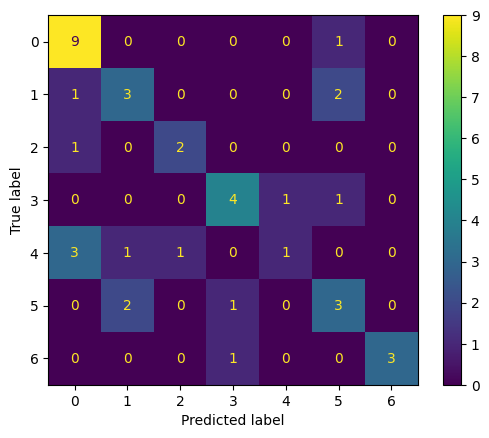


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['fear(3)']



In [41]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [42]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [43]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.8502, Val Loss: 1.7437, Val F1 Macro: 0.2543
Epoch 2/25, Train Loss: 1.5640, Val Loss: 1.5665, Val F1 Macro: 0.3901
Epoch 3/25, Train Loss: 1.3638, Val Loss: 1.4491, Val F1 Macro: 0.4234
Epoch 4/25, Train Loss: 1.2204, Val Loss: 1.3611, Val F1 Macro: 0.4963
Epoch 5/25, Train Loss: 1.1139, Val Loss: 1.2901, Val F1 Macro: 0.4844
Epoch 6/25, Train Loss: 1.0334, Val Loss: 1.2402, Val F1 Macro: 0.4837
Epoch 7/25, Train Loss: 0.9723, Val Loss: 1.2125, Val F1 Macro: 0.5569
Epoch 8/25, Train Loss: 0.9249, Val Loss: 1.2015, Val F1 Macro: 0.5280
Epoch 9/25, Train Loss: 0.8865, Val Loss: 1.1955, Val F1 Macro: 0.5575
Epoch 10/25, Train Loss: 0.8548, Val Loss: 1.1937, Val F1 Macro: 0.5575
Epoch 11/25, Train Loss: 0.8280, Val Loss: 1.1969, Val F1 Macro: 0.5538
Epoch 12/25, Train Loss: 0.8048, Val Loss: 1.2012, Val F1 Macro: 0.5538
Epoch 13/25, Train Loss: 0.7843, Val Loss: 1.2085, Val F1 Macro: 0.5436
Epoch 14/25, Train Loss: 0.7657, Val Loss: 1.2152, Val F1 Macro: 0.5436
E


Evaluation: f1_score
71.82% for the train data
57.67% for the test data

Evaluation: accuracy_score
74.23% for the train data
60.98% for the test data

Evaluation: precision_score
72.75% for the train data
59.89% for the test data

Evaluation: recall_score
72.00% for the train data
58.10% for the test data

Evaluation: confusion_matrix of test predictions


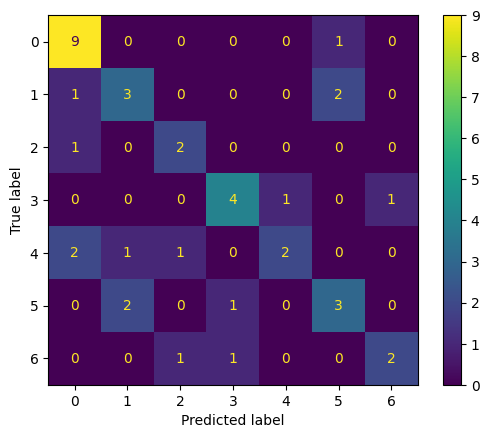


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)', 'sadness(6)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['disgust(2)', 'fear(3)']
Hard cases of false positives: ['fear(3)']



In [44]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

Feature selection in this small subset does not help at all.

### Repeat with 90-5-5 as they did in paper

In [45]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.1)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,median,min,var,f1_median,f1_max,f1_mean,f1_std,f1_var,f2_median,f2_max,...,f3_avg_change_rate_min,f3_avg_change_rate_mean,f3_avg_change_rate_median,f3_avg_change_rate_var,f4_min,f4_avg_change_rate_max,f4_avg_change_rate_min,f4_avg_change_rate_mean,f4_avg_change_rate_median,f4_avg_change_rate_var
237,0.179508,-0.652108,0.398483,-0.910195,0.867241,-0.836544,0.972100,0.818601,-0.675433,2.301220,...,0.281342,-0.571515,-2.421321,1.134351,2.532017,-1.128242,0.936666,-0.642279,-1.023195,-0.050438
459,0.228894,-0.652108,-0.451518,-0.594862,0.479114,-0.582301,0.051272,-0.082693,0.169959,-0.188910,...,-0.435149,1.212373,0.212935,-0.207111,0.108335,-1.018174,1.073194,0.839805,-0.068708,-1.061572
142,2.464448,-0.652108,3.804069,-1.235926,0.811069,-0.218788,1.109326,0.971293,0.258974,3.024731,...,-1.732089,-1.071855,0.958744,0.370705,-1.027376,-0.454119,0.359252,-0.102290,-0.291171,-0.342364
148,0.984505,-0.652108,0.124783,-0.377024,0.002248,-0.514863,-0.171951,-0.268858,1.033327,0.275566,...,-0.168794,-0.715513,0.004755,0.726086,-0.191502,0.458023,-1.160187,0.005342,0.679895,2.186467
124,-1.093013,1.606945,-1.157279,1.591598,-1.310297,1.488478,-0.280482,-0.354813,0.797993,-1.158205,...,-1.441704,0.283201,-0.938220,-0.189211,0.432228,-0.226709,0.064645,0.431431,0.364636,-0.685866


There are 481 entries with 108 columns in the training data.
There are 54 entries with 108 columns in the testing data.


In [46]:
# define train, test, and val loader
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [47]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [48]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.8592, Val Loss: 1.7496, Val F1 Macro: 0.1448
Epoch 2/25, Train Loss: 1.6120, Val Loss: 1.5649, Val F1 Macro: 0.2853
Epoch 3/25, Train Loss: 1.3469, Val Loss: 1.3270, Val F1 Macro: 0.2902
Epoch 4/25, Train Loss: 1.1067, Val Loss: 1.1260, Val F1 Macro: 0.3927
Epoch 5/25, Train Loss: 0.9319, Val Loss: 0.9936, Val F1 Macro: 0.5136
Epoch 6/25, Train Loss: 0.7978, Val Loss: 0.8846, Val F1 Macro: 0.6852
Epoch 7/25, Train Loss: 0.6885, Val Loss: 0.7972, Val F1 Macro: 0.6779
Epoch 8/25, Train Loss: 0.5946, Val Loss: 0.7243, Val F1 Macro: 0.6286
Epoch 9/25, Train Loss: 0.5144, Val Loss: 0.6675, Val F1 Macro: 0.6144
Epoch 10/25, Train Loss: 0.4458, Val Loss: 0.6196, Val F1 Macro: 0.6144
Epoch 11/25, Train Loss: 0.3860, Val Loss: 0.5800, Val F1 Macro: 0.6644
Epoch 12/25, Train Loss: 0.3346, Val Loss: 0.5469, Val F1 Macro: 0.7129
Epoch 13/25, Train Loss: 0.2897, Val Loss: 0.5166, Val F1 Macro: 0.7991
Epoch 14/25, Train Loss: 0.2505, Val Loss: 0.4904, Val F1 Macro: 0.7991
E


Evaluation: f1_score
100.00% for the train data
63.83% for the test data

Evaluation: accuracy_score
100.00% for the train data
66.67% for the test data

Evaluation: precision_score
100.00% for the train data
71.43% for the test data

Evaluation: recall_score
100.00% for the train data
63.44% for the test data

Evaluation: confusion_matrix of test predictions


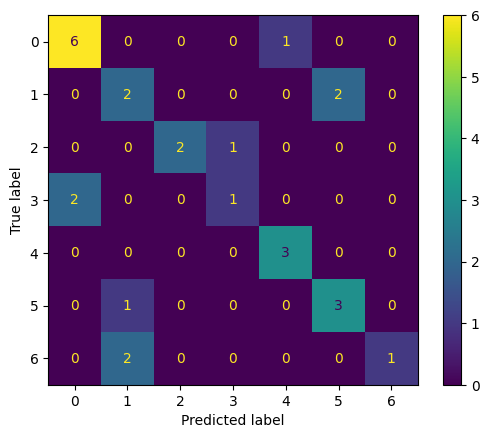


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['fear(3)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['sadness(6)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [49]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [50]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [51]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.6350, Val Loss: 1.2998, Val F1 Macro: 0.5061
Epoch 2/25, Train Loss: 1.1475, Val Loss: 1.0420, Val F1 Macro: 0.5667
Epoch 3/25, Train Loss: 0.9308, Val Loss: 0.8821, Val F1 Macro: 0.7163
Epoch 4/25, Train Loss: 0.7971, Val Loss: 0.7816, Val F1 Macro: 0.6772
Epoch 5/25, Train Loss: 0.6891, Val Loss: 0.7021, Val F1 Macro: 0.6707
Epoch 6/25, Train Loss: 0.5986, Val Loss: 0.6383, Val F1 Macro: 0.7279
Epoch 7/25, Train Loss: 0.5195, Val Loss: 0.5863, Val F1 Macro: 0.7279
Epoch 8/25, Train Loss: 0.4509, Val Loss: 0.5454, Val F1 Macro: 0.7120
Epoch 9/25, Train Loss: 0.3908, Val Loss: 0.5095, Val F1 Macro: 0.7583
Epoch 10/25, Train Loss: 0.3376, Val Loss: 0.4796, Val F1 Macro: 0.8042
Epoch 11/25, Train Loss: 0.2910, Val Loss: 0.4538, Val F1 Macro: 0.8068
Epoch 12/25, Train Loss: 0.2505, Val Loss: 0.4331, Val F1 Macro: 0.8626
Epoch 13/25, Train Loss: 0.2149, Val Loss: 0.4166, Val F1 Macro: 0.8626
Epoch 14/25, Train Loss: 0.1845, Val Loss: 0.4059, Val F1 Macro: 0.8150
E


Evaluation: f1_score
100.00% for the train data
59.78% for the test data

Evaluation: accuracy_score
100.00% for the train data
62.96% for the test data

Evaluation: precision_score
100.00% for the train data
67.01% for the test data

Evaluation: recall_score
100.00% for the train data
59.86% for the test data

Evaluation: confusion_matrix of test predictions


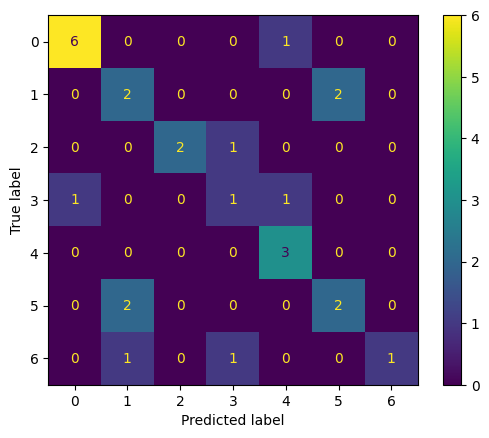


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']
Hard cases of false positives: ['disgust(2)', 'sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)', 'fear(3)']



In [52]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Best Model GFFNN with PCA

In [53]:
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0

In [54]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.3, verbose=False)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

In [55]:
# define train, test, and val loader
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, 
                       worker_init_fn=seed_worker,generator=g)

In [56]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [57]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.7055, Val Loss: 1.4067, Val F1 Macro: 0.4126
Epoch 2/25, Train Loss: 1.2674, Val Loss: 1.1432, Val F1 Macro: 0.5130
Epoch 3/25, Train Loss: 1.0359, Val Loss: 0.9946, Val F1 Macro: 0.5996
Epoch 4/25, Train Loss: 0.8826, Val Loss: 0.8989, Val F1 Macro: 0.6599
Epoch 5/25, Train Loss: 0.7657, Val Loss: 0.8270, Val F1 Macro: 0.6949
Epoch 6/25, Train Loss: 0.6695, Val Loss: 0.7655, Val F1 Macro: 0.7396
Epoch 7/25, Train Loss: 0.5873, Val Loss: 0.7122, Val F1 Macro: 0.7569
Epoch 8/25, Train Loss: 0.5153, Val Loss: 0.6705, Val F1 Macro: 0.7712
Epoch 9/25, Train Loss: 0.4510, Val Loss: 0.6388, Val F1 Macro: 0.7712
Epoch 10/25, Train Loss: 0.3936, Val Loss: 0.6146, Val F1 Macro: 0.8018
Epoch 11/25, Train Loss: 0.3423, Val Loss: 0.5959, Val F1 Macro: 0.7901
Epoch 12/25, Train Loss: 0.2967, Val Loss: 0.5831, Val F1 Macro: 0.7938
Epoch 13/25, Train Loss: 0.2565, Val Loss: 0.5738, Val F1 Macro: 0.8079
Epoch 14/25, Train Loss: 0.2213, Val Loss: 0.5683, Val F1 Macro: 0.7722
E


Evaluation: f1_score
100.00% for the train data
70.67% for the test data

Evaluation: accuracy_score
100.00% for the train data
74.07% for the test data

Evaluation: precision_score
100.00% for the train data
73.69% for the test data

Evaluation: recall_score
100.00% for the train data
71.41% for the test data

Evaluation: confusion_matrix of test predictions


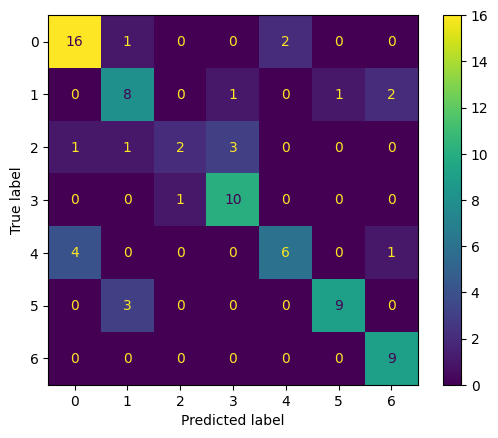


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['fear(3)']

Label: fear(3)
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [58]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)